In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arafatsahinafridi/multi-class-driver-behavior-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/multi-class-driver-behavior-image-dataset


Discovered classes: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']
Epoch 1/50 Train Loss: 0.4147 Val Loss:   0.1746 Train Acc:  0.8464 Val Acc:    0.9382 Time: 126.0s
  -> Saved model (val_loss improved to 0.1746)
Epoch 2/50 Train Loss: 0.1160 Val Loss:   0.1530 Train Acc:  0.9574 Val Acc:    0.9375 Time: 131.6s
  -> Saved model (val_loss improved to 0.1530)
Epoch 3/50 Train Loss: 0.0813 Val Loss:   0.1692 Train Acc:  0.9699 Val Acc:    0.9361 Time: 132.8s
Epoch 4/50 Train Loss: 0.0613 Val Loss:   0.1698 Train Acc:  0.9773 Val Acc:    0.9334 Time: 132.9s
Epoch 5/50 Train Loss: 0.0479 Val Loss:   0.1549 Train Acc:  0.9823 Val Acc:    0.9505 Time: 132.5s
Epoch 6/50 Train Loss: 0.0285 Val Loss:   0.1244 Train Acc:  0.9919 Val Acc:    0.9602 Time: 132.7s
  -> Saved model (val_loss improved to 0.1244)
Epoch 7/50 Train Loss: 0.0287 Val Loss:   0.3660 Train Acc:  0.9916 Val Acc:    0.9258 Time: 133.5s
Epoch 8/50 Train Loss: 0.0299 Val Loss:   0.1497 Train Ac

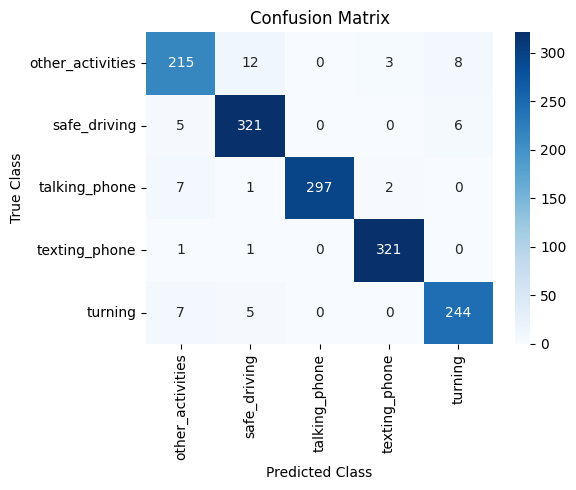

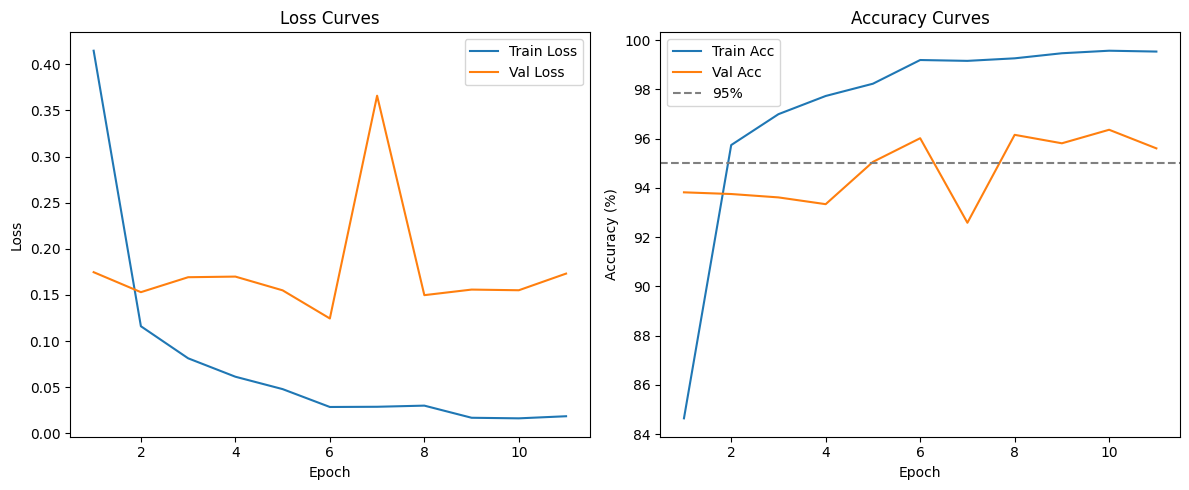

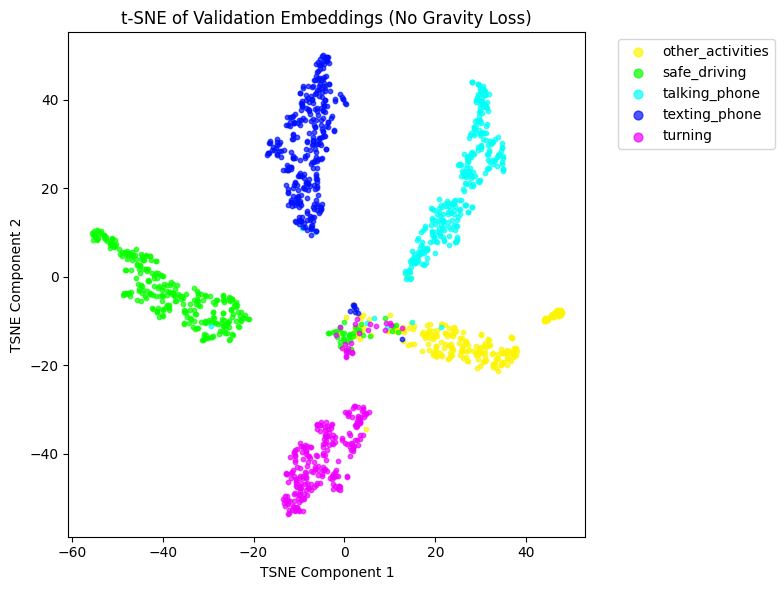

In [ ]:
# ================= 0. Imports & Config =================
import os
import time
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.manifold import TSNE

# -------- User configuration --------
DATA_DIR        = "/kaggle/input/multi-class-driver-behavior-image-dataset/Multi-Class Driver Behavior Image Dataset"
IMG_SIZE        = 224
BATCH_SIZE      = 64
NUM_WORKER      = 2            # Kaggle recommends ≤2
EPOCHS          = 50           # maximum epochs
PATIENCE        = 5            # early-stopping patience
LR              = 3e-4
EMBED_DIM       = 512
NUM_CLASS       = 5

DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = "best_model_no_gravity.pth"
LOG_PATH        = "training_log_no_gravity.json"

# ================= 1. Data =================
trans_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
trans_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

full_ds = datasets.ImageFolder(DATA_DIR, transform=trans_train)
print("Discovered classes:", full_ds.classes)

train_len = int(0.8 * len(full_ds))
val_len   = len(full_ds) - train_len
train_ds, val_ds = random_split(
    full_ds, [train_len, val_len],
    generator=torch.Generator().manual_seed(42)
)
val_ds.dataset.transform = trans_val

train_ld = DataLoader(train_ds,  BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKER, pin_memory=True)
val_ld   = DataLoader(val_ds,    BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKER, pin_memory=True)

# ================= 2. Model =================
backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
backbone.fc = nn.Sequential(
    nn.Linear(backbone.fc.in_features, EMBED_DIM),
    nn.ReLU(inplace=True)
)
classifier = nn.Linear(EMBED_DIM, NUM_CLASS)
backbone, classifier = backbone.to(DEVICE), classifier.to(DEVICE)

# ================= 3. Loss & Optimizer =============
criterion = nn.CrossEntropyLoss()
params    = list(backbone.parameters()) + list(classifier.parameters())
optimizer = optim.Adam(params, lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ================= 4. Training Loop with Early Stopping =
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
best_val_loss     = float('inf')
epochs_no_improve = 0

for epoch in range(1, EPOCHS+1):
    start = time.time()
    for phase in ("train", "val"):
        is_train = (phase == "train")
        backbone.train(is_train)
        classifier.train(is_train)
        loader = train_ld if is_train else val_ld

        running_loss, correct, total = 0.0, 0, 0
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            with torch.set_grad_enabled(is_train):
                feats  = backbone(imgs)
                logits = classifier(feats)
                loss   = criterion(logits, lbls)
                if is_train:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * lbls.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == lbls).sum().item()
            total   += lbls.size(0)

        epoch_loss = running_loss / total
        epoch_acc  = correct / total
        history[f"{phase}_loss"].append(epoch_loss)
        history[f"{phase}_acc"].append(epoch_acc)

    scheduler.step()
    elapsed = time.time() - start
    print(f"Epoch {epoch}/{EPOCHS} "
          f"Train Loss: {history['train_loss'][-1]:.4f} "
          f"Val Loss:   {history['val_loss'][-1]:.4f} "
          f"Train Acc:  {history['train_acc'][-1]:.4f} "
          f"Val Acc:    {history['val_acc'][-1]:.4f} "
          f"Time: {elapsed:.1f}s")

    # Early stopping & saving
    val_loss = history["val_loss"][-1]
    if val_loss < best_val_loss:
        best_val_loss     = val_loss
        epochs_no_improve = 0
        torch.save({
            "backbone_state_dict":  backbone.state_dict(),
            "classifier_state_dict": classifier.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch,
            "history": history
        }, BEST_MODEL_PATH)
        print(f"  -> Saved model (val_loss improved to {best_val_loss:.4f})")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping after {epoch} epochs (no improvement).")
            break

# Save training history
with open(LOG_PATH, "w") as fp:
    json.dump(history, fp)

print("Training complete. Best model saved to", BEST_MODEL_PATH)

# ================= 5. Evaluation & Visualizations =================
# Load best model
checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
backbone.load_state_dict(checkpoint["backbone_state_dict"])
classifier.load_state_dict(checkpoint["classifier_state_dict"])
backbone.eval(); classifier.eval()

# Inference on validation set
all_preds, all_labels, all_feats = [], [], []
with torch.no_grad():
    for imgs, lbls in val_ld:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        feats  = backbone(imgs)
        logits = classifier(feats)
        preds  = logits.argmax(dim=1)
        all_feats.append(feats.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

all_feats  = np.concatenate(all_feats)
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec  = recall_score(all_labels, all_preds, average='weighted')
f1   = f1_score(all_labels, all_preds, average='weighted')
print(f"\nValidation Accuracy : {acc:.4f}")
print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall   : {rec:.4f}")
print(f"Validation F1-score : {f1:.4f}\n")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_ds.classes, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_ds.classes,
            yticklabels=full_ds.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()

# Training & validation curves
epochs = range(1, len(history["train_loss"])+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves"); plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, np.array(history["train_acc"])*100, label="Train Acc")
plt.plot(epochs, np.array(history["val_acc"])*100,   label="Val Acc")
plt.axhline(95, color='gray', ls='--', label="95%")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy Curves"); plt.legend()
plt.tight_layout(); plt.show()

# t-SNE of embeddings
tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=30)
feats_2d = tsne.fit_transform(all_feats)
plt.figure(figsize=(8,6))
palette = sns.color_palette("hsv", NUM_CLASS)
for idx, cls in enumerate(full_ds.classes):
    mask = all_labels == idx
    plt.scatter(feats_2d[mask,0], feats_2d[mask,1],
                s=10, color=palette[idx], label=cls, alpha=0.7)
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc='upper left')
plt.title("t-SNE of Validation Embeddings (No Gravity Loss)")
plt.xlabel("TSNE Component 1"); plt.ylabel("TSNE Component 2")
plt.tight_layout(); plt.show()
